<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/simulated_annealing_2d_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulate annealing on a 2d surface

Code is heavily based on

https://krischer.github.io/seismo_live_build/html/Seismic%20Inverse%20Problems/Probabilistic%20Inversion/pi_simann_wrapper.html

Heiner Igel (@heinerigel)
Kilian Gessele (@KGessele)
Berta Vilacís (@bvilacis)


In [9]:

import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from IPython import display


from mpl_toolkits.mplot3d import Axes3D

In [173]:

!mkdir figures
!mkdir scripts
%cd /content/scripts
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py
import pyprobml_utils as pml


/content/scripts


# Target distribution

We use  the [peaks](https://www.mathworks.com/help/matlab/ref/peaks.html) function from matlab, modified so it is positive:
$$
p(x,y) \propto  |3 (1-x)^2 e^{-x^2 - (y+1)^2}  
   - 10 (\frac{x}{5} - x^3 - y^5) e^{-x^2 -y^2} 
   - \frac{1}{3} e^{-(x+1)^2 - y^2} |
$$


In [195]:
# Generate a pdf

# the following steps generate a pdf; this is equivalent to the function "peaks(n)" in matlab
n = 100 # number of dimension
pdf = np.zeros([n,n])
sigma = np.zeros([n,n])
s = np.zeros([n,n])
x = -3.
for i in range(0,n):
    y = -3.
    for j in range(0,n):
        pdf[j,i]=3.*(1-x)**2*np.exp(-(x**2)-(y+1)**2)-10.*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1./3*np.exp(-(x+1)**2-y**2)
        if pdf[j,i] < 0:
            pdf[j,i] = pdf[j,i] * (-1) # in contrast to the peaks function: all negative values are multiplied by (-1)
        y = y + 6./(n-1)
    x = x + 6./(n-1)

pdf = pdf / pdf.max()
energy  = -np.log(pdf) 

<IPython.core.display.Javascript object>

saving image to ../figures/sim_anneal_2d_peaks.pdf


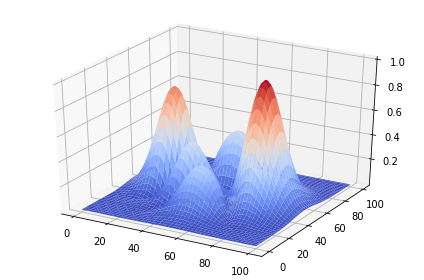

In [196]:
# Plot the 3D plot of pdf
# --------------------------

X = np.arange(0,100 + 100./(n-1), 100./(n-1))
Y = np.arange(0,100 + 100./(n-1), 100./(n-1))
fig0 = plt.figure()
ax = fig0.gca(projection='3d')
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(Y, X, pdf,rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.1)
#plt.gca().invert_xaxis()
plt.tight_layout()
pml.savefig('sim_anneal_2d_peaks.pdf')
plt.show()

<IPython.core.display.Javascript object>

saving image to ../figures/sim_anneal_2d_energy.pdf


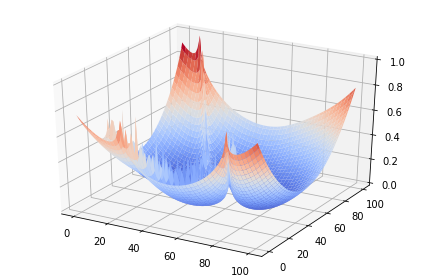

In [197]:
# Plot the 3D plot of Energy function
# --------------------------

X = np.arange(0,100 + 100./(n-1), 100./(n-1))
Y = np.arange(0,100 + 100./(n-1), 100./(n-1))
fig0 = plt.figure()
ax = fig0.gca(projection='3d')
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(Y, X, energy/energy.max(),rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.1)
#plt.gca().invert_xaxis()
plt.tight_layout()
pml.savefig('sim_anneal_2d_energy.pdf')
plt.show()

# Heat bath

The "heat bath" refers to a modified version of the distribution in which we vary the temperature. 

<IPython.core.display.Javascript object>

saving image to ../figures/sim_anneal_2d_cooled0.pdf


<IPython.core.display.Javascript object>

saving image to ../figures/sim_anneal_2d_cooled1.pdf


<IPython.core.display.Javascript object>

saving image to ../figures/sim_anneal_2d_cooled2.pdf


<IPython.core.display.Javascript object>

saving image to ../figures/sim_anneal_2d_cooled3.pdf


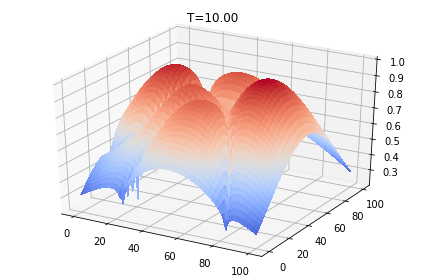

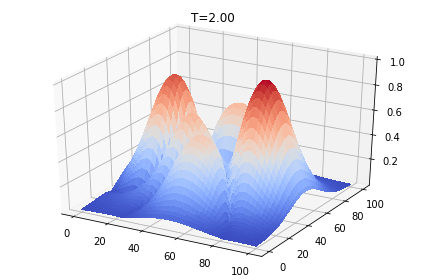

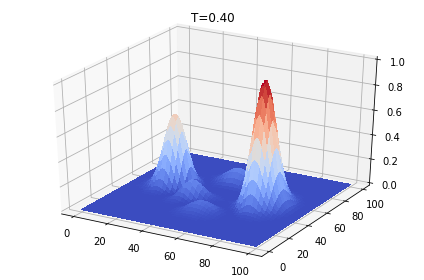

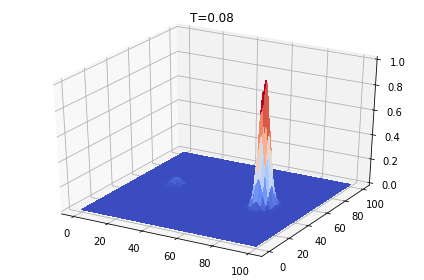

In [198]:
Tplots = 10 # inicial temperature for the plots
stepT = 4 #how many steps should the Temperature be *0.1 evolved

for i in range(0,stepT): 
    sigma = np.exp(-(energy)/Tplots) 
    sigma= sigma / sigma.max()
    ttl = 'T={:0.2f}'.format(Tplots)    
    Tplots = Tplots * 0.2
    X = np.arange(0,100 + 100./(n-1), 100./(n-1))
    Y = np.arange(0,100 + 100./(n-1), 100./(n-1))
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(X, Y)
    ax.set_title(ttl)
    ax.plot_surface(Y, X, sigma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    #plt.gca().invert_xaxis()
    plt.tight_layout()
    pml.savefig(f'sim_anneal_2d_cooled{i}.pdf')

plt.show()

# SA algorithm

In [205]:
np.random.seed(42)


# find an initial vector x
xcur = np.array([np.floor(np.random.uniform(0, 100)), np.floor(np.random.uniform(0, 100))])
xinit = xcur

ns = 300   # number of samples to keep 
T = 1 # start temperature
alpha = 0.99999 #cooling schedule
alpha = 0.99 #cooling schedule

iis = 0 # number of accepted points
npp = 0 # num proposed points

# array of points visited
xa = np.array([])
xa = np.hstack((xa, np.array([xcur[0],xcur[1]])))
# list of probabilities of visited points
Pa = [0]

xnew = np.array([0.,0.])
temp_hist = []
nreject = 0
#while iis < ns: 
while npp < ns: 
    npp = npp+1
    if True:
      #independent random sample for the next move
      xnew = np.array([np.floor(np.random.uniform(0, 100)), np.floor(np.random.uniform(0, 100))])
    else:
      # gaussian proposal
      xnew = xcur + np.random.random(2)*10
      # Clip to upper and lower bounds
      xnew = np.maximum(xnew, 0)
      xnew = np.minimum(xnew, 99)
      xnew = np.array([int(xnew[0]), int(xnew[1])])

    #compare energies
    Ecur = energy[int(xcur[0]), int(xcur[1])]
    Enew = energy[int(xnew[0]), int(xnew[1])]
    deltaE = Enew - Ecur

    #print([npp, xcur, xnew, Ecur, Enew, deltaE])
    
    temp_hist.append(T)
    T = alpha * T
    P = np.exp(-1. * deltaE / T)
    P = min(1, P)
    test = np.random.uniform(0,1)
    if test <= P: 
      xcur = xnew
      iis = iis + 1
    else:
      nreject += 1
   
    xa = np.vstack((xa, np.array([xcur[0],xcur[1]])))
    
npp = npp + 1
print(f'nproposed {npp}, naccepted {iis}, nreject {nreject}')
print(T)


nproposed 301, naccepted 33, nreject 267
0.04904089407128576


<IPython.core.display.Javascript object>

saving image to ../figures/sim_anneal_2d_temp_vs_time.pdf


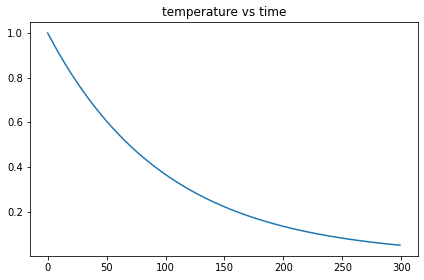

In [200]:

plt.figure()
plt.plot(temp_hist)
plt.title('temperature vs time')
plt.tight_layout()
pml.savefig(f'sim_anneal_2d_temp_vs_time.pdf')
plt.show()

<IPython.core.display.Javascript object>

saving image to ../figures/sim_anneal_2d_prob_vs_time.pdf


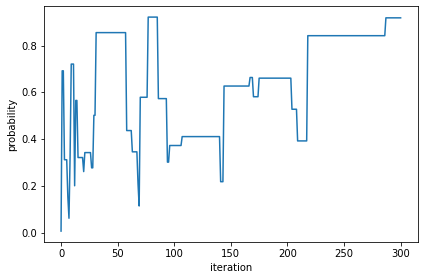

In [206]:
probs = []
n = len(xa)
for i in range(n):
  x0 = int(xa[i,0])
  x1 = int(xa[i,1])
  probs.append(pdf[x0, x1])

plt.figure()
plt.plot(probs)
plt.xlabel('iteration')
plt.ylabel('probability')
plt.tight_layout()
pml.savefig(f'sim_anneal_2d_prob_vs_time.pdf')
plt.show()

# Final results

<IPython.core.display.Javascript object>

saving image to ../figures/sim_anneal_2d_samples.pdf


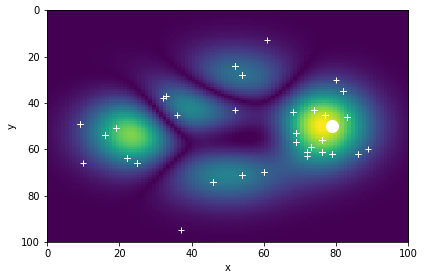

In [202]:
# Plot points visited
maxi = np.argmax(probs) # index of best model
f1, ax = plt.subplots()
ax.imshow(pdf.transpose(),aspect='auto', extent=[0,100,100,0],interpolation='none')
#ax.imshow(pdf,aspect='auto', extent=[0,100,100,0],interpolation='none')
ax.plot(xa[:,0],xa[:,1],'w+') #Plot the steps with white +
ax.plot(xa[maxi,0],xa[maxi,1],'wo', markersize=12) #Maximum value acchieved ploted wiht the white cirlce
ax.set_ylabel('y')
ax.set_xlabel('x')
plt.tight_layout()
pml.savefig(f'sim_anneal_2d_samples.pdf')
plt.show()

